---
# A novel optimal approach towards classification of skin lesions
---
## Model 3 - **HHORegSANet (*RegNetY032 with Soft Attention, and optimal parameters found using Harris-Hawks Optimization*)**
---

## Importing the Libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout
%matplotlib inline
import shutil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from PIL import ImageFile

## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Extracting the dataset from zip file

In [ ]:
from zipfile import ZipFile
filename="/content/drive/MyDrive/HAM10000.zip"
with ZipFile(filename,'r') as zip:
  zip.extractall()
  print("Zip extracted.")

Zip extracted.


## Exploratory Data Analysis (EDA)

In [ ]:
data_pd = pd.read_csv('/content/drive/MyDrive/HAM10000_metadata.csv')
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1


In [ ]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [ ]:
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no'
    else:
        return 'duplicates'

In [ ]:
data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates


In [ ]:
df_ham = data_pd[data_pd['is_duplicate'] == 'no']

## Functions to count, and plot image-count histograms

In [ ]:
def count_images_in_subfolders(root_folder):
    image_counts = {}

    for foldername, subfolders, filenames in os.walk(root_folder):
        folder_name = os.path.basename(foldername)  # Extract the subfolder name
        for filename in filenames:
            # Check if the file has a common image extension (you can customize this list)
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_counts[folder_name] = image_counts.get(folder_name, 0) + 1
    image_counts = dict(sorted(image_counts.items()))
    return image_counts

In [ ]:
def plot_histogram(image_counts, title):
    folders = list(image_counts.keys())
    counts = list(image_counts.values())
    plt.bar(folders, counts, color='blue')
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title(title)
    plt.show()

## Train-test split

In [ ]:
train_df, temp_df = train_test_split(df_ham, test_size=0.2, stratify=df_ham['dx'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['dx'])

**stratify=df_ham['dx']** ensures that the splitting is done in a way that preserves the proportion of samples for each class label in the column 'dx' (stratified sampling).

In [ ]:
def identify_train_test(x):
    train_data = set(train_df['image_id'])
    val_data = set(val_df['image_id'])
    test_data = set(test_df['image_id'])
    if str(x) in train_data:
        return 'train'
    elif str(x) in val_data:
        return 'val'
    else:
        return 'test'

In [ ]:
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
6563,HAM_0005644,ISIC_0027899,nv,follow_up,45.0,male,back,no
6541,HAM_0003103,ISIC_0031921,nv,follow_up,40.0,female,trunk,no
8988,HAM_0005102,ISIC_0028128,nv,histo,55.0,male,chest,no
4096,HAM_0000697,ISIC_0029148,nv,follow_up,40.0,male,abdomen,no
6270,HAM_0003385,ISIC_0025839,nv,follow_up,40.0,female,back,no


In [ ]:
val_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
2139,HAM_0006355,ISIC_0027663,mel,histo,40.0,male,back,no
5780,HAM_0004740,ISIC_0024992,nv,follow_up,40.0,male,abdomen,no
3987,HAM_0001771,ISIC_0030556,nv,follow_up,55.0,male,trunk,no
10001,HAM_0000020,ISIC_0031922,akiec,histo,60.0,female,face,no
6509,HAM_0001844,ISIC_0026736,nv,follow_up,70.0,male,abdomen,no


In [ ]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
3390,HAM_0002286,ISIC_0029876,nv,follow_up,40.0,female,trunk,no
5925,HAM_0003266,ISIC_0029468,nv,follow_up,30.0,male,abdomen,no
4540,HAM_0001659,ISIC_0026564,nv,follow_up,35.0,male,lower extremity,no
3775,HAM_0007467,ISIC_0029085,nv,follow_up,65.0,female,lower extremity,no
8473,HAM_0006855,ISIC_0030842,nv,histo,50.0,male,back,no


In [ ]:
# Image id of train and test images
train_list = list(train_df['image_id'])
val_list = list(val_df['image_id'])
test_list = list(test_df['image_id'])

In [ ]:
print('Before Augmentation')
print(f'Number of train images: {len(train_list)}')
print(f'Number of validation images: {len(val_list)}')
print(f'Number of test images: {len(test_list)}')

Before Augmentation
Number of train images: 4411
Number of validation images: 551
Number of test images: 552


In [ ]:
# Set the image_id as the index in data_pd
data_pd.set_index('image_id', inplace=True)

## Organizing the dataset into folders

In [ ]:
base_dir = '/content/HAM10000/'

In [ ]:
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')
test_dir = os.path.join(base_dir, 'test_dir')

In [ ]:
os.mkdir(train_dir)
os.mkdir(val_dir)
os.mkdir(test_dir)

In [ ]:
classes = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

In [ ]:
for c in classes:
    os.mkdir(train_dir + '/' + c)
    os.mkdir(val_dir + '/' + c)
    os.mkdir(test_dir + '/' + c)

In [ ]:
for image in train_list:
    file_name = image + '.jpg'
    label = data_pd.loc[image, 'dx'].upper()

    # path of source image
    source = os.path.join(base_dir, file_name)

    # moving the image from the source to target directory
    target = os.path.join(train_dir, label, file_name)

    shutil.move(source, target)

In [ ]:
for image in val_list:
    file_name = image + '.jpg'
    label = data_pd.loc[image, 'dx'].upper()

    # path of source image
    source = os.path.join(base_dir, file_name)

    # moving the image from the source to target directory
    target = os.path.join(val_dir, label, file_name)

    shutil.move(source, target)

In [ ]:
for image in test_list:
    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx'].upper()

    # path of source image
    source = os.path.join(base_dir, file_name)

    # moving the image from the source to target directory
    target = os.path.join(test_dir, label, file_name)

    shutil.move(source, target)

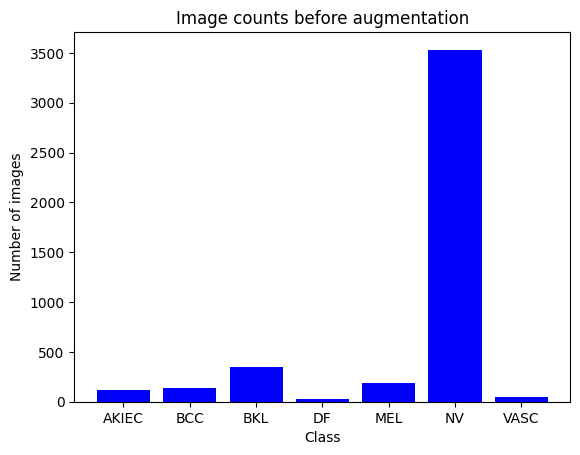

In [ ]:
root_folder = "/content/HAM10000/train_dir"
image_counts = count_images_in_subfolders(root_folder)
plot_histogram(image_counts, "Image counts before augmentation")

In [ ]:
classes = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

# Augmenting images and storing them in temporary directories
for img_class in classes:

    #creating temporary directories
    # creating a base directory
    aug_dir = '/content/HAM10000/aug_dir'
    os.mkdir(aug_dir)
    # creating a subdirectory inside the base directory for images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_list = os.listdir('/content/HAM10000/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir
    for file_name in img_list:

        # path of source image in training directory
        source = os.path.join('/content/HAM10000/train_dir/' + img_class, file_name)

        # creating a target directory to send images
        target = os.path.join(img_dir, file_name)

        # copying the image from the source to target file
        shutil.copyfile(source, target)

    # Temporary augumented dataset directory.
    source_path = aug_dir

    # Augmented images will be saved to training directory
    save_path = '/content/HAM10000/train_dir/' + img_class

    # Creating Image Data Generator to augment images
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.3,
        brightness_range=[0.5, 1.5],
        zoom_range=0.3,
        fill_mode='nearest'
    )

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(source_path,
                                              save_to_dir=save_path,
                                              save_format='jpg',
                                              target_size=(224, 224),
                                              batch_size=batch_size)

    # Generate the augmented images
    aug_images = 8000
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    # creating 8000 augmented images per class
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # delete temporary directory
    shutil.rmtree('/content/HAM10000/aug_dir')

Found 121 images belonging to 1 classes.
Found 140 images belonging to 1 classes.
Found 352 images belonging to 1 classes.
Found 31 images belonging to 1 classes.
Found 184 images belonging to 1 classes.
Found 3532 images belonging to 1 classes.
Found 51 images belonging to 1 classes.


In [ ]:
base_dir = '/content/HAM10000'
train_path = os.path.join(base_dir, 'train_dir')
val_path = os.path.join(base_dir, 'val_dir')
test_path = os.path.join(base_dir, 'test_dir')
batch_size=16

In [ ]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.regnet.preprocess_input)

In [ ]:
image_size = 224

In [ ]:
print("Train Images: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

Train Images: 
Found 45668 images belonging to 7 classes.


In [ ]:
print("Validation Images: ")
val_batches = datagen.flow_from_directory(directory=val_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)

Validation Images: 
Found 551 images belonging to 7 classes.


In [ ]:
print("Test Images: ")
test_batches = datagen.flow_from_directory(directory=test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)

Test Images: 
Found 552 images belonging to 7 classes.


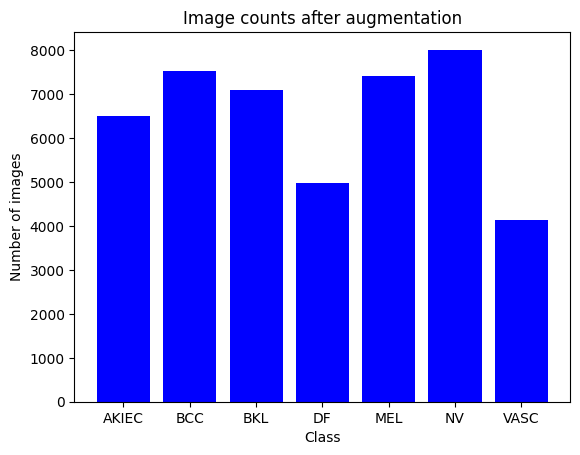

In [ ]:
root_folder = "/content/HAM10000/train_dir"
image_counts = count_images_in_subfolders(root_folder)
plot_histogram(image_counts, "Image counts after augmentation")

## Model creation

In [ ]:
regnet = tf.keras.applications.regnet.RegNetY032(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
)

# Exclude the last 3 layers of the model.
conv = regnet.layers[-3].output

78924456/78924456 [==============================] - 4s 0us/step


## Soft Attention Layer

In [ ]:
class SoftAttention(Layer):
    def __init__(self, ch, m, concat_with_x=False, aggregate=False, **kwargs):
        # Initializing SoftAttention layer with parameters:
        # ch: Number of channels
        # m: Number of attention heads
        # concat_with_x: Whether to concatenate scaled features with original features
        # aggregate: Whether to aggregate attention maps across channels
        self.channels = int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x
        super(SoftAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Building the SoftAttention layer
        self.i_shape = input_shape

        # Define kernel shape for 3D convolution
        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads)  # DHWC

        # Define output shapes for attention maps and features
        self.out_attention_maps_shape = input_shape[0:1] + (self.multiheads,) + input_shape[1:-1]
        if self.aggregate_channels == False:
            self.out_features_shape = input_shape[:-1] + (input_shape[-1] + (input_shape[-1] * self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1] + (input_shape[-1] * 2,)
            else:
                self.out_features_shape = input_shape

        # Initialize convolutional kernel and bias
        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                              initializer='he_uniform',
                                              name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                            initializer='zeros',
                                            name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):
        # Define operations performed during the call of SoftAttention layer

        # Expand dimensions of input tensor
        exp_x = K.expand_dims(x, axis=-1)

        # Perform 3D convolution
        c3d = K.conv3d(exp_x,
                       kernel=self.kernel_conv3d,
                       strides=(1, 1, self.i_shape[-1]),
                       padding='same',
                       data_format='channels_last')
        conv3d = K.bias_add(c3d, self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        # Permute dimensions for further processing
        conv3d = K.permute_dimensions(conv3d, pattern=(0, 4, 1, 2, 3))
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d, shape=(-1, self.multiheads, self.i_shape[1] * self.i_shape[2]))

        # Apply softmax to obtain attention maps
        softmax_alpha = K.softmax(conv3d, axis=-1)
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1], self.i_shape[2]))(softmax_alpha)

        if self.aggregate_channels == False:
            # Expand dimensions and permute for further processing
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha, pattern=(0, 2, 3, 1, 4))
            x_exp = K.expand_dims(x, axis=-2)

            # Multiply to obtain scaled features
            u = kl.Multiply()([exp_softmax_alpha, x_exp])
            u = kl.Reshape(target_shape=(self.i_shape[1], self.i_shape[2], u.shape[-1] * u.shape[-2]))(u)
        else:
            # Aggregate attention maps and multiply to obtain scaled features
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha, pattern=(0, 2, 3, 1))
            exp_softmax_alpha = K.sum(exp_softmax_alpha, axis=-1)
            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)
            u = kl.Multiply()([exp_softmax_alpha, x])

        if self.concat_input_with_scaled:
            # Concatenate scaled features with original features
            o = kl.Concatenate(axis=-1)([u, x])
        else:
            o = u

        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        # Define output shapes
        return [self.out_features_shape, self.out_attention_maps_shape]

    def get_config(self):
        # Get configuration
        return super(SoftAttention, self).get_config()

In [ ]:
attention_layer, map2 = SoftAttention(aggregate=True, m=16, concat_with_x=False, ch=int(conv.shape[-1]), name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv, attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)

In [ ]:
# Modifying the original head of RegNetY032
output = GlobalAveragePooling2D()(conv)
output = Dense(512, activation='relu')(output)
output = Dropout(0.5)(output)
output = Dense(7, activation='softmax')(output)

In [ ]:
model = Model(inputs=regnet.input, outputs=output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 regnety032_prestem_rescali  (None, 224, 224, 3)          0         ['input_1[0][0]']             
 ng (Rescaling)                                                                                   
                                                                                                  
 regnety032_stem_conv (Conv  (None, 112, 112, 32)         864       ['regnety032_prestem_rescaling
 2D)                                                                [0][0]']                      
                                                                                              

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00934439, epsilon=0.1)
model.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

## Model Checkpoints definition

In [ ]:
checkpoint=  ModelCheckpoint(filepath = '/content/drive/MyDrive/hhoregsanet.hdf5',
                             monitor = 'val_accuracy',
                             save_best_only = True,
                             save_weights_only = True)

## Defining the Early Stopping criteria

In [ ]:
Earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=40, min_delta=0.001)

## Model training

In [ ]:
history = model.fit(train_batches,
                    steps_per_epoch=(len(train_df)/10),
                    epochs=100,
                    verbose=2,
                    batch_size=16,
                    validation_data=val_batches,
                    validation_steps=len(test_df)/batch_size,
                    callbacks=[checkpoint,Earlystop])

Epoch 1/100
918/918 [==============================] - 503s 509ms/step - loss: 1.6802 - accuracy: 0.4590 - val_loss: 1.6202 - val_accuracy: 0.4040
Epoch 2/100
918/918 [==============================] - 156s 170ms/step - loss: 1.0757 - accuracy: 0.6770 - val_loss: 1.0107 - val_accuracy: 0.6220
Epoch 3/100
918/918 [==============================] - 89s 97ms/step - loss: 0.8838 - accuracy: 0.7361 - val_loss: 0.8238 - val_accuracy: 0.6811
Epoch 4/100
918/918 [==============================] - 85s 92ms/step - loss: 0.7815 - accuracy: 0.7691 - val_loss: 0.7815 - val_accuracy: 0.7101
Epoch 5/100
918/918 [==============================] - 91s 99ms/step - loss: 0.6861 - accuracy: 0.8008 - val_loss: 0.7311 - val_accuracy: 0.7478
Epoch 6/100
918/918 [==============================] - 84s 92ms/step - loss: 0.6157 - accuracy: 0.8202 - val_loss: 0.6557 - val_accuracy: 0.7612
Epoch 7/100
918/918 [==============================] - 84s 92ms/step - loss: 0.5773 - accuracy: 0.8336 - val_loss: 0.6373 - va

## Epochs vs Accuracy

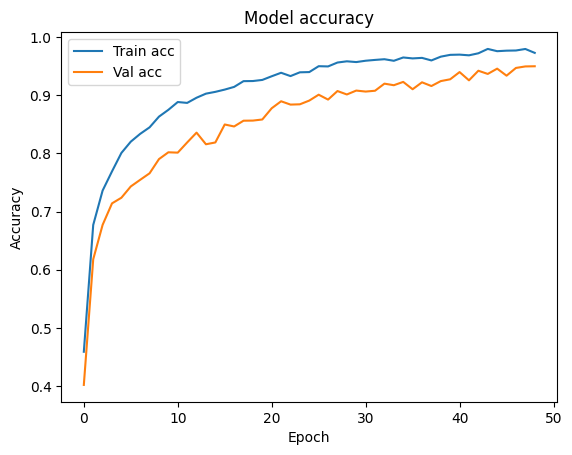

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train acc', 'Val acc'], loc='upper left')
plt.show()

## Epochs vs Loss

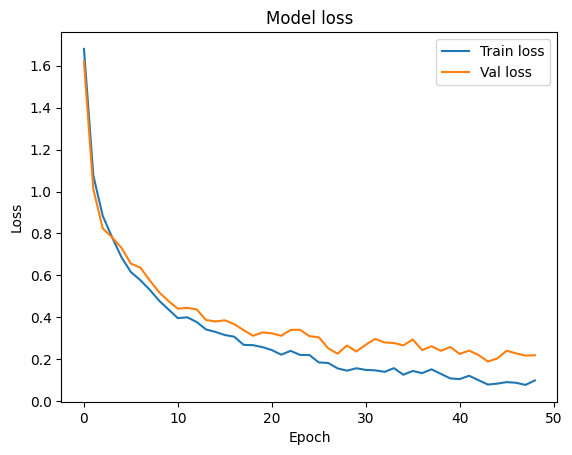

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.show()

## Model Evaluation

In [ ]:
model.load_weights("/content/drive/MyDrive/hhoregsanet.hdf5")

In [ ]:
predictions = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=1)

34/34 [==============================] - 123s 3s/step


### 1. Classification Report

In [ ]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob=predictions
y_test = to_categorical(y_true)

# Creating classification report
report = classification_report(y_true, y_pred, target_names=targetnames)

print(report)

              precision    recall  f1-score   support

          AK       1.00      1.00      1.00        23
         BCC       0.93      1.00      0.96        26
         BKL       1.00      0.97      0.98        66
          DF       1.00      0.83      0.91         6
         MEL       1.00      0.94      0.97        34
          NV       0.99      1.00      1.00       663
        VASC       1.00      1.00      1.00        10

    accuracy                           0.99       828
   macro avg       0.99      0.96      0.97       828
weighted avg       0.99      0.99      0.99       828



### 2. Confusion Matrix

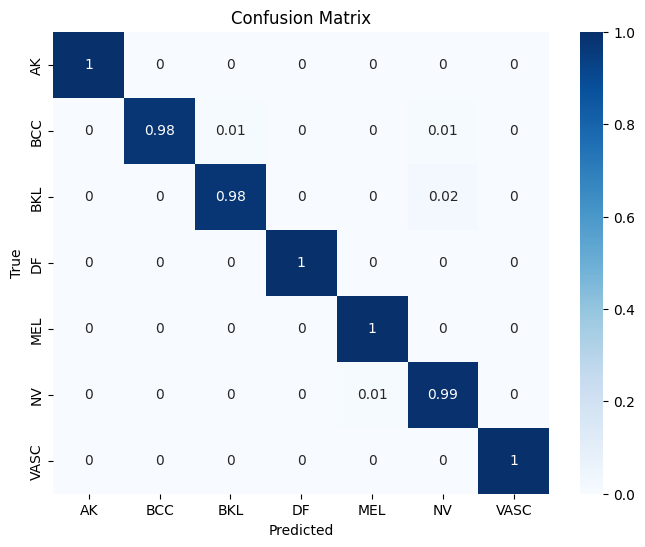

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize='true')
classes = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
# Plotting the confusion matrix as a blue heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 3. Accuracy, Precision, Recall and F1-Score

In [ ]:
print(f'Test accuracy: {accuracy_score(y_true, y_pred)}')

Test accuracy: 0.9927536231884058


In [ ]:
precision = round(precision_score(y_true, y_pred, average='weighted'), 4)
recall = round(recall_score(y_true, y_pred, average='weighted'), 4)
f1_score = round(f1_score(y_true, y_pred, average='weighted'), 4)

In [ ]:
print(f'Precision = {precision}')
print(f'Recall = {recall}')
print(f'F1-Score = {f1_score}')

Precision = 0.9924
Recall = 0.9907
F1-Score = 0.9914


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn+fp)
print(f'Specificity = {round(specificity, 4)}')

Specificity = 0.9909


### 4. ROC Curves

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of AK is: 1.0
The ROC AUC score of BCC is: 1.0
The ROC AUC score of BKL is: 0.9930654974946314
The ROC AUC score of DF is: 1.0
The ROC AUC score of MEL is: 0.9939179748500041
The ROC AUC score of NV is: 0.9962978198272316
The ROC AUC score of VASC is: 1.0


In [ ]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

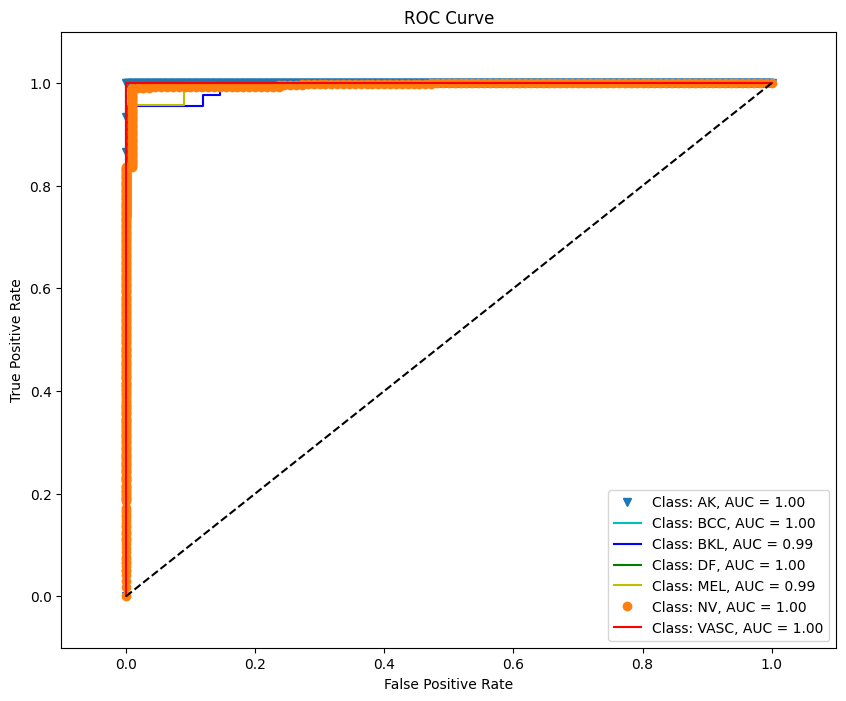

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(fpr[0], tpr[0],'v',label='Class: AK, AUC = %0.2f' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='Class: BCC, AUC = %0.2f' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='Class: BKL, AUC = %0.2f' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='Class: DF, AUC = %0.2f' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='Class: MEL, AUC = %0.2f' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o',label='Class: NV, AUC = %0.2f' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='Class: VASC, AUC = %0.2f' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

---